# Sequence deep learning

In [3]:
# 단어 수준의 원-핫 인코딩하기
import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1
            
max_length = 10
results  = np.zeros(shape=(len(samples), max_length, max(token_index.values())+1))

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

In [4]:
# 문자 수준 원-핫 인코딩하기
import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable # 출력 가능한 모든 아스키 문자
token_index = dict(zip(characters, range(1, len(characters)+1)))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values())+1))

for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        results[i, j, index] = 1.

In [5]:
# 케라스를 사용한 단어 수준의 원-핫 인코딩하기
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words = 1000) # 가장 빈도가 높은 100개 단어만 선택
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples) # 문자열을 정수 인덱스의 리스트로 변환

one_hot_reults = tokenizer.texts_to_matrix(samples, mode='binary') # 원핫 인코딩
word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

9개의 고유한 토큰을 찾았습니다.


In [6]:
# 해싱 기법을 사용한 단어 수준의 원-핫 인코딩하기
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

## Embedding 층을 사용하여 단어 임베딩 학습하기

In [7]:
# Embedding 층의 객체 생성하기
from keras.layers import Embedding

embedding_layer = Embedding(1000, 64) 

In [8]:
# Embedding 층에 사용할 IMDB 데이터 로드하기
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000 # 특성으로 사용할 단어의 수
maxlen = 20 # 사용할 텍스트의 길이(가장 빈번한 max_features개의 단어만 사용합니다.)

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features) # 정수 리스트로 데이터 로드
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

17465344/17464789 [==============================] - 3s 0us/step


In [9]:
# IMDB 데이터에 Embedding 층과 분류기 사용하기
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten()) # 3D 임베딩 텐서를 (samples, maxlen*8) 크기의 2D 텐서로 펼침
model.add(Dense(1, activation='sigmoid')) # 분류기 추가
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.6707 - acc: 0.6188 - val_loss: 0.6224 - val_acc: 0.6978
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.5466 - acc: 0.7490 - val_loss: 0.5271 - val_acc: 0.7308
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4651 - acc: 0.7876 - val_loss: 0.4982 - 

## 사전 훈련된 단어 임베딩 사용하기

In [10]:
# IMDB 원본 데이터 전처리하기
import os

imdb_dir = './datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [11]:
# IMDB 원본 데이터의 텍스트를 토큰화하기
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # 100개 단어 이후는 버림
training_samples = 2000 # 훈련 샘플은 200개
validation_samples = 10000 # 검증 샘플은 1만 개
max_words = 10000 # 데이터셋에서 가장 빈도 높은 1만 개 단어만 사용

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('데이터 텐서의 크기: ', data.shape)
print('레이블 텐서의 크기: ', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples+validation_samples]
y_val = labels[training_samples: training_samples+validation_samples]

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기:  (25000, 100)
레이블 텐서의 크기:  (25000,)


In [12]:
# GloVe 단어 임베딩 파일 파싱하기
glove_dir = './datasets/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('%s 개의 단어 벡터를 찾았습니다.' % len(embeddings_index))

400000 개의 단어 벡터를 찾았습니다.


In [13]:
# GloVe 단어 임베딩 행렬 준비하기
from tqdm.notebook import tqdm
embedding_dim = 100
    
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i, in tqdm(word_index.items()):
    if i<max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [14]:
embedding_matrix.shape

(10000, 100)

## 모델 정의하기

In [15]:
# 모델 정의하기
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [16]:
# 사전 훈련된 단어 임베딩을 Embedding 층에 로드하기
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [17]:
# 훈련과 평가하기
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
history = model.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_data = (x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
63/63 [==============================] - 1s 23ms/step - loss: 0.7873 - acc: 0.5165 - val_loss: 0.6902 - val_acc: 0.5245
Epoch 2/10
63/63 [==============================] - 1s 21ms/step - loss: 0.7140 - acc: 0.5555 - val_loss: 0.6831 - val_acc: 0.6141
Epoch 3/10
63/63 [==============================] - 1s 21ms/step - loss: 0.6632 - acc: 0.6315 - val_loss: 0.6560 - val_acc: 0.6081
Epoch 4/10
63/63 [==============================] - 2s 28ms/step - loss: 0.5771 - acc: 0.7155 - val_loss: 0.6709 - val_acc: 0.5965
Epoch 5/10
63/63 [==============================] - 1s 20ms/step - loss: 0.4249 - acc: 0.8075 - val_loss: 0.6611 - val_acc: 0.6307
Epoch 6/10
63/63 [==============================] - 1s 19ms/step - loss: 0.3370 - acc: 0.8660 - val_loss: 0.8191 - val_acc: 0.6009
Epoch 7/10
63/63 [==============================] - 1s 21ms/step - loss: 0.2554 - acc: 0.9030 - val_loss: 0.7436 - val_acc: 0.6316
Epoch 8/10
63/63 [==============================] - 2s 34ms/step - loss: 0.2272 - a

OSError: Unable to create file (unable to open file: name = 'pre_trained_glove_model.h5', errno = 13, error message = 'Permission denied', flags = 13, o_flags = 242)

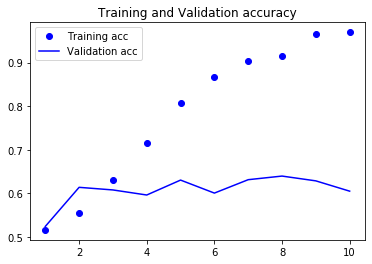

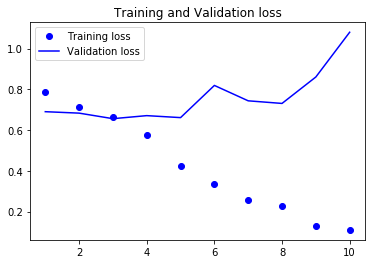

In [18]:
# 결과 그래프 그리기
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [20]:
# 사전 훈련된 단어 임베딩을 사용하지 않고 같은 모델 훈련하기
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val,y_val))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
63/63 [==============================] - 2s 29ms/step - loss: 0.6845 - acc: 0.5615 - val_loss: 0.6558 - val_acc: 0.6438
Epoch 2/10
63/63 [==============================] - 3s 50ms/step - loss: 0.3084 - acc: 0.9465 - val_loss: 0.544

In [21]:
# 테스트 데이터 토큰화하기
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen = maxlen)
y_test = np.asarray(labels)


In [27]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 5s 7ms/step - loss: 0.7324 - acc: 0.5738


[0.7324022054672241, 0.5738000273704529]